# Community analysis of gene regulatory networks inferred from COVID-19 patients

This notebook contains the community analysis of gene-gene regulatory networks computed on scRNA-seq data of COVID-19 patients ([Liao *et al.*, 2020](https://www.nature.com/articles/s41591-020-0901-9)). The community analysis focuses on the identification of subgroups of genes that are highly-connected. As we are working with GRNs the assumption is that highly-connected gene sets should substitute groups with common functionality in cells (e.g. immune signaling community, cell division community, etc). In this notebook, we would plot these communities and visualize them as interconnected wordclouds. Words will describe each community by showing most important genes within each community (based on centrality measure) or based on the functional analysis.

The following questions could be answered:

- Is there an underlying structure or any gene grouping in gene regulatory networks (GRNs)?
- Do genes group based on their function?
- Can we reproduce cell regulation using data-focused approach?

# Setting up the environment..

In [1]:
# Generic
import sys  # managing environmental variables
import os  # file system
import warnings  # managing warnings
from glob import glob  # globbing
import multiprocessing  # parallel execution

# Data managing
import ndex2  # database of biological network
import numpy as np  # scientific programming
import pandas as pd  # working with tabular data

# Graphs
import networkx as nx  # working with network data
import igraph as ig  # working with network data
import leidenalg as la  # community detection
from community import community_louvain  # community detection
from venn import venn, pseudovenn, generate_petal_labels, draw_venn, draw_pseudovenn6  # venn diagram visualization

# Visualization
import matplotlib as mpl  # general visualization
import matplotlib.pyplot as plt  # general visualization
import seaborn as sns  # fancy visualizations
import colorcet as cc  # colormaps
from matplotlib.colors import ListedColormap  # colormaps
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches  # color patches
from wordcloud import WordCloud  # wordcloud visualization
import matplotlib_venn_wordcloud  # workcloud visualization

# Tools/utils
from sklearn.preprocessing import MinMaxScaler  # scaling data
from collections import Counter  # item counter
from functools import reduce  # for aggregate functions
from termcolor import colored  # colored text output
from tqdm.notebook import tqdm  # progress bar logging
import itertools  # tools for iterative objects
from itertools import chain, zip_longest
import textwrap
import re
import time

# Setting working directory as home
home_dir = os.path.expanduser('~')
os.chdir(os.path.expanduser('~/scGRN_analysis'))
multiprocessing.process.ORIGINAL_DIR = os.path.abspath(os.getcwd())

# Getting the tools for GRN analysis
import scGRN

# Jupyter utils
from IPython.display import display  # displaying results in jupyter
from ipywidgets import *  # interactive widgets

# Bridge to R
import rpy2.rinterface
%load_ext rpy2.ipython

# To reload packages - # %autoreload 2
%load_ext autoreload
# To obtain line-by-line profile of execution time
%load_ext line_profiler

# Other parameters
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
_N_JOBS = max(1, multiprocessing.cpu_count() - 2)
_SEED = 42
np.random.seed(_SEED)
_NODE_SIZE = 1200
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.dpi'] = 200
sns.set_style("whitegrid")
blue = (221 / 256, 232 / 256, 250 / 256)
dark_blue = (115 / 256, 141 / 256, 187 / 256)
yellow = (253 / 256, 242 / 256, 208 / 256)
dark_yellow = (209 / 256, 183 / 256, 101 / 256)

# Loading ggplot2 default colors
colors = scGRN.ggcolors

# Setting up data
## Getting metadata

In [2]:
# Setting pathways to data files
_PROJ_HOME = '/gpfs/projects/bsc08/shared_projects/scGRN_analysis'  # also scGRN._PROJ_HOME
_FMETA = f'{_PROJ_HOME}/Data_home/data/GSE145926_RAW/metadata.tsv'  # also scGRN._META_FILE
_DATA_HOME = f'{_PROJ_HOME}/Data_home/res/covid_19'  # also scGRN._DATA_HOME
_FIG_HOME = f'{_PROJ_HOME}/Data_home/notebook_figs'

# Loading patient metadata
full_meta = scGRN.ana.get_meta(_DATA_HOME, _FMETA)

# Displaying full metadata
print('Full metadata:')
full_meta

Full metadata:


,group,file,num_cells,Macrophage,T_cells,DC,Pre-B_cell_CD34-,Monocyte,NK_cell,B_cell,...,Neutrophils,GMP,Erythroblast,Gametocytes,Neurons,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
id,,,,,,,,,,,,,,,,,,,,,
C51,C,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,9431.0,8348.0,608.0,215.0,98.0,70.0,68.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C52,C,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,8696.0,8611.0,13.0,23.0,3.0,14.0,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C100,C,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,907.0,338.0,411.0,45.0,5.0,51.0,20.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C141,M,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,1449.0,197.0,932.0,48.0,5.0,86.0,96.0,33.0,...,11.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C142,M,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,1790.0,482.0,996.0,39.0,13.0,67.0,113.0,20.0,...,14.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C144,M,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,452.0,37.0,181.0,41.0,8.0,73.0,34.0,14.0,...,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C143,S,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,14933.0,2048.0,1394.0,154.0,33.0,7489.0,562.0,72.0,...,3005.0,2.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN
C145,S,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,15550.0,6960.0,719.0,859.0,46.0,5616.0,421.0,58.0,...,635.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C146,S,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,2545.0,247.0,61.0,36.0,NaN,127.0,14.0,3.0,...,1632.0,NaN,NaN,1.0,NaN,2.0,1.0,1.0,1.0,NaN


## Setting up namespace

Here we will define useful info that will help us to navigate through data.

In [3]:
# Data types
_PAT_TYPES = ['C', 'M', 'S']  # control, moderate and severe
_NET_TYPES = ['all', 'TF', 'ctx']  # all gene-gene connections, TF-target connections, enriched TF-target connections

# Defining quantile when filtering low-confident nodes from GRNs
_Q_THRESH = 0.95

# Getting cell type count for each patient
full_cell_type_dist = full_meta.iloc[:, 3:]

_LOADED_PATIENTS = []
_LOADED_CELL_TYPES = []

# Getting information about all patients
_ALL_CELL_TYPES = full_cell_type_dist.columns.to_list()
_ALL_PATIENTS = full_meta.index.to_list()
_ALL_PAT_CELL_TYPES = {  # available cell types per patient
    pat: scGRN.ana.get_avail_pat_sc(pat, as_data_fn=False).remove('all_data') for pat in _ALL_PATIENTS
}
_ALL_PAT_FILENAMES = {  # obtained data files per patient
    pat: scGRN.ana.get_avail_pat_sc(pat, as_data_fn=True) for pat in _ALL_PATIENTS
}
_ALL_FIG_DIRS = {
    **{  # figure directory paths per patient
        pat: os.path.join(_DATA_HOME, pat, 'figs/grnboost2') for pat in _ALL_PATIENTS
    }, 
    **{  # common figure directory for aggregated patient data
        pat: _FIG_HOME for pat in ['C', 'M', 'S', 'all_data']
    }
}

for fig_dir in _ALL_FIG_DIRS.values():  # creating folders for figures per patient
    os.makedirs(fig_dir, exist_ok=True)

# Loading exemplary data - also possible to use scGRN.ana.get_sc_data(data='all_data', pat=ex_pat)
ex_pat = 'C141'
ex_df = pd.read_csv(os.path.join(_DATA_HOME, f'{ex_pat}/data/Seurat/raw_data.tsv'), sep='\t').T

# Quick reporting
print(f'As an example, the expression matrix of {colored(ex_pat, "green")} patient contains '
      f'{colored(ex_df.shape[0], "green")} cells and {colored(ex_df.shape[1], "green")} genes:')
display(ex_df.head())
print('Common cell types among different patients (full metadata):')
display(full_cell_type_dist.T.dropna())

As an example, the expression matrix of C141 patient contains 1449 cells and 20271 genes:


,AL627309.1,AL669831.2,AL669831.5,FAM87B,LINC00115,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,...,BX004987.1,AC145212.1,MAFIP,AC011043.1,AL592183.1,AC007325.1,AC007325.4,AC007325.2,AL354822.1,AC240274.1
AAACCTGAGATGTCGG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGCAATCCGAT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGCATGGTCAT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGGTTTAGCTG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAACCTGTCAATCACG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Common cell types among different patients (full metadata):


id,C51,C52,C100,C141,C142,C144,C143,C145,C146,C148,C149,C152
Macrophage,8348.0,8611.0,338.0,197.0,482.0,37.0,2048.0,6960.0,247.0,98.0,176.0,466.0
T_cells,608.0,13.0,411.0,932.0,996.0,181.0,1394.0,719.0,61.0,122.0,681.0,397.0
DC,215.0,23.0,45.0,48.0,39.0,41.0,154.0,859.0,36.0,24.0,80.0,41.0
Monocyte,70.0,14.0,51.0,86.0,67.0,73.0,7489.0,5616.0,127.0,641.0,691.0,795.0
NK_cell,68.0,5.0,20.0,96.0,113.0,34.0,562.0,421.0,14.0,36.0,59.0,74.0
B_cell,9.0,2.0,12.0,33.0,20.0,14.0,72.0,58.0,3.0,8.0,38.0,317.0
Epithelial_cells,7.0,25.0,18.0,37.0,38.0,54.0,145.0,207.0,417.0,52.0,41.0,201.0


## Setting up additional data

We would also need additional data about TFs, NDEx networks and functional annotation of genes. 

In [4]:
# Setting pathways to auxiliary files
_NDEX_DATA = f'{_PROJ_HOME}/Data_home/data/ndex/'
_TF_LIST_lambert = f'{_PROJ_HOME}/Data_home/data/TF_lists/lambert2018.txt'
_TF_LIST_dorothea = f'{_PROJ_HOME}/Data_home/data/TF_lists/dorothea_regulons.tsv'

# Loading TFs, Lambert et al, 2018 is by default
TF_names = lambert_TF_names = pd.read_csv(_TF_LIST_lambert, header=None)[0].to_list()
dorothea_TF_names = list(
    pd.read_csv(_TF_LIST_dorothea, sep='\t') \
        .loc[lambda x: x['confidence'].isin(['A', 'B', 'C'])]['tf'].unique()
)

# Loading gene GO description - it was downloaded using ENSEMBL BioMart
GO_annotation = scGRN.ana.load_gene_func_db('GO')

## Available data reporting

Here we will visualize available data through dataframe formatting. Also we will show what cell types (and their quantity) are present in each patients.

In [5]:
check, missing, cross = u'\u2713', '?', u'\u2715'  # green, red, yellow

# Getting scRNA-seq data availability
_AVAIL_scDATA = scGRN.ana.get_avail_sc_data(
    data_home=_DATA_HOME,
    meta_file=_FMETA
)

# Displaying the scRNA-seq data availability
display(scGRN.util.style_bool_df(_AVAIL_scDATA))

# Printing the legend
print(colored('Legend:', 'green'))
print('all_data: The aggregated data, e.g. ("all_data", "Macrophage") - all macrophages, ("C152", "all_data") - all cells from C152.')
print(f'{check}: Data is processed and ready for use')
print(f'{missing}: Failed to detect the data file, although the corresponding cell type is present in patient')
print(f'{cross}: The corresponding cell type is not present in patient')

,all_data,Macrophage,T_cells,DC,Pre-B_cell_CD34-,Monocyte,NK_cell,B_cell,Epithelial_cells,BM,Pro-B_cell_CD34+,HSC_-G-CSF,CMP,Neutrophils,GMP,Erythroblast,Gametocytes,Neurons,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
all_data,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,?,?,?,?,?,?,?
C,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
M,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,✕,✕,✕,✕,✕,✕,✕
S,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,✕,?,?,?,?,?,?,?
C51,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C52,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C100,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C141,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C142,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C144,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕


Legend:
all_data: The aggregated data, e.g. ("all_data", "Macrophage") - all macrophages, ("C152", "all_data") - all cells from C152.
✓: Data is processed and ready for use
?: Failed to detect the data file, although the corresponding cell type is present in patient
✕: The corresponding cell type is not present in patient


## Availability of NetworkX graphs for different datasets

In [6]:
# Getting adjacency list/NetworkX object availability matrices
_AVAIL_ADJ_LISTs = scGRN.ana.get_avail_adj_lists(
    data_home=_DATA_HOME,
    meta_file=_FMETA
)
_AVAIL_Gs = scGRN.ana.get_avail_nx_graphs(
    data_home=_DATA_HOME,
    meta_file=_FMETA
)

# Visualizing the GRN availability matrix
for net_type in _NET_TYPES:
    print(f"{colored(net_type, 'cyan')}-type networks")
    display(scGRN.util.style_bool_df(_AVAIL_Gs[net_type]))

# Printing the legend
check, missing, cross = u'\u2713', '?', u'\u2715'  # green, red, #8B8000
print(colored('Legend:', 'green'))
print('all_data: The aggregated data, e.g. ("all_data", "Macrophage") - all macrophages, ("C152", "all_data") - all cells from C152.')
print(f'{check}: Data is processed and ready for use')
print(f'{missing}: Failed to detect the data file, although the corresponding cell type is present in patient')
print(f'{cross}: The corresponding cell type is not present in patient')

all-type networks


,all_data,Macrophage,T_cells,DC,Pre-B_cell_CD34-,Monocyte,NK_cell,B_cell,Epithelial_cells,BM,Pro-B_cell_CD34+,HSC_-G-CSF,CMP,Neutrophils,GMP,Erythroblast,Gametocytes,Neurons,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
all_data,?,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,?,?,?,?,?,?,?
C,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
M,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,✕,✕,✕,✕,✕,✕,✕
S,?,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,✕,?,?,?,?,?,?,?
C51,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C52,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C100,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C141,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C142,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C144,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕


TF-type networks


,all_data,Macrophage,T_cells,DC,Pre-B_cell_CD34-,Monocyte,NK_cell,B_cell,Epithelial_cells,BM,Pro-B_cell_CD34+,HSC_-G-CSF,CMP,Neutrophils,GMP,Erythroblast,Gametocytes,Neurons,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
all_data,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,?,?,?,?,?,?,?
C,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
M,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,✕,✕,✕,✕,✕,✕,✕
S,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,✕,?,?,?,?,?,?,?
C51,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C52,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C100,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C141,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C142,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✕,✕,✕,✕,✕
C144,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✓,✕,✕,✕,✕,✕,✕,✕


ctx-type networks


,all_data,Macrophage,T_cells,DC,Pre-B_cell_CD34-,Monocyte,NK_cell,B_cell,Epithelial_cells,BM,Pro-B_cell_CD34+,HSC_-G-CSF,CMP,Neutrophils,GMP,Erythroblast,Gametocytes,Neurons,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
all_data,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,?,?,?,?,?,?,?
C,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
M,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,?,✕,✕,✕,✕,✕,✕,✕
S,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,?,✕,?,?,?,?,?,?,?
C51,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C52,✓,✓,✓,✓,✓,✓,✓,?,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C100,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,?,✕,✓,✕,✕,✕,✕,✕,✕,✕,✕,✕,✕
C141,✓,✓,✓,✓,✓,✓,✓,✓,✓,✕,✕,✕,✓,✓,?,✕,✕,✕,✕,✕,✕,✕,✕
C142,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,✓,✓,?,✕,✕,✕,✕,✕,✕,✕,✕
C144,✓,✓,✓,✓,✓,✓,✓,✓,✓,?,?,?,?,✓,✕,?,✕,✕,✕,✕,✕,✕,✕


Legend:
all_data: The aggregated data, e.g. ("all_data", "Macrophage") - all macrophages, ("C152", "all_data") - all cells from C152.
✓: Data is processed and ready for use
?: Failed to detect the data file, although the corresponding cell type is present in patient
✕: The corresponding cell type is not present in patient


## Setting up useful functions - mainly for `ipywidgets`

In [7]:
def load_community_genes(pat, cell_type, algo, limit_anno_until):
    """
    Load central genes from each community calculated during previous runs and stored in pickle format. 
    Calculating central genes is a long process, so we can restore ths result from saved file.
    """
        
    try:
        df = scGRN.ana.get_community_info(pat=pat, cell_type=cell_type, algo=algo)
        print(f'Successfully loaded previously saved results at {data_as}!')
        all_partition_genes = {
            i: {
                el[:el.find(' ')]: float(el[el.find('=') + 1: -1]) for el in df.loc[i, 'all_sorted_genes'].split('; ')
            } for i in df.index
        }
        central_gene_scores = {
            i: {
                gene_name: gene_score for k, (gene_name, gene_score) in enumerate(gene_scores.items()) if k < limit_anno_until
            } for i, gene_scores in all_partition_genes.items()
        }
        norm_partition_genes = {
            i: dict(zip(
                gene_scores.keys(), 
                scGRN.util.scale_int(list(gene_scores.values()), 1, 100)
            )) for i, gene_scores in central_gene_scores.items()
        }
        
        return norm_partition_genes
        
    except OSError as e:
        
        print('No previously saved results, rerunning calculation of central genes')
        return True


def data_fn_to_cell_type(data):
    """
    Transform data file identifier to cell type, e.g. "raw_data_Macrophage" -> "Macrophage"
    """
    
    return 'all_data' if data == 'raw_data' else data.replace('raw_data_', '')

def format_pat(p):
    """
    Format patient name `p` to a nice view, e.g. "C51 (C) - RAM", "C".
    """
    
    if p in ['all_data'] + _PAT_TYPES:
        return p
    else:
        is_RAM = ' - RAM' if p in _LOADED_PATIENTS else ''
        pat_type = f"{full_meta.loc[p, 'group']}"
        return f"{p} ({pat_type}){is_RAM}"

def format_data(p, ct, add_ram_tag=True):
    """
    Format data name corresponding to `p` (patient) and `ct` (cell type) to a nice view, e.g. "T_cells (2800 cells)""
    """
    
    if ct == 'all_data':
        tag = 'all_data'
        col_key = 'num_cells'
    else:
        col_key = tag = ct
            
    if p in ['all_data', 'C', 'M', 'S']:
        curr_meta = full_meta[full_meta['group'] == p] if p != 'all_data' else full_meta
        num_cells = int(curr_meta[col_key].sum())
    else:
        num_cells = int(full_meta.loc[p, col_key])
        
    is_RAM = ' - RAM' if tag in _LOADED_CELL_TYPES and add_ram_tag else ''
        
    return f'{tag} ({num_cells} cells){is_RAM}'

def gen_avail_data(_):
    """
    Generates a list of data options depending on passed information (for `ipywidgets`).
    """
    c_type_dropdown.options = [
        (
            format_data(p_dropdown.value, c_type), 
            c_type
        ) for c_type in scGRN.ana.get_avail_pat_nx(n_type_dropdown.value, p_dropdown.value, as_data_fn=False)
    ]
    
def gen_dropdowns():
    """
    Generate `ipywidgets` Dropdown objects to interact with jupyter notebook. 
    """
    _n_type_dropdown = Dropdown(
        description='Net type:', options=_NET_TYPES
    )
    _p_dropdown = Dropdown(
        description='Patient:', 
        options=[(format_pat(p), p) for p in _ALL_PATIENTS + ['C', 'M', 'S', 'all_data']]
    )
    _c_type_dropdown = Dropdown(
        description='Cell type:', 
        options=[
            (
                format_data(_ALL_PATIENTS[0], c_type), 
                c_type
            ) for c_type in scGRN.ana.get_avail_pat_nx('all', _ALL_PATIENTS[0], as_data_fn=False)
        ]
    )
    _p_dropdown.observe(gen_avail_data, names='value')
    _n_type_dropdown.observe(gen_avail_data, names='value')

    return _p_dropdown, _c_type_dropdown, _n_type_dropdown
    
sf_dropdown = Dropdown(
    description='Save figure:', options=[False, True]
)
fltrd_dropdown = Dropdown(
    description=f'Filtered (quantile threshold={_Q_THRESH}): ', options=[False, True]
)
p_type_dropdown = Dropdown(
    description='Patient type:', options=_PAT_TYPES
)

# Number of communities (clusters) in different cell types

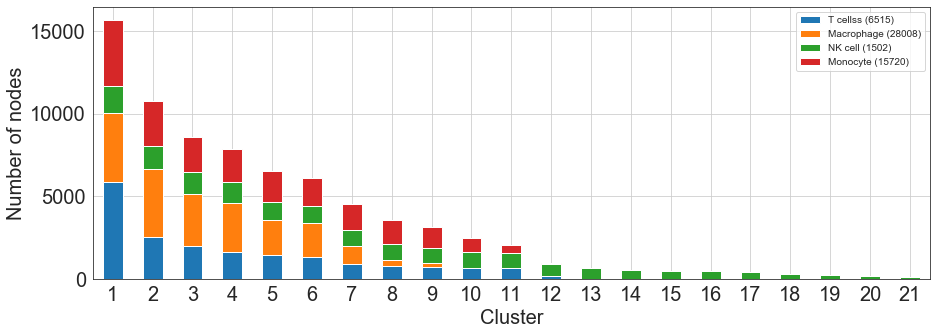

In [8]:
algo = 'leiden'
pat_types = ['all_data', 'C', 'M', 'S']
cell_types = ['T_cells', 'Macrophage', 'NK_cell', 'Monocyte']

titles = {
    t: (
        f'{t.replace("_", " ")} ({scGRN.ana.get_num_cells(pat="all_data", cell_type=t, meta=full_meta)})' if not t.endswith('s')
        else f'{t.replace("_", " ")}s ({scGRN.ana.get_num_cells(pat="all_data", cell_type=t, meta=full_meta)})'
    ) for t in cell_types
}

with sns.axes_style("white"):
    
    df = pd.concat([
        scGRN.ana.get_community_info(curr_type, algo=algo)[
            'num_nodes'
        ].rename(curr_type) for curr_type in cell_types
    ], axis=1).fillna(0).rename(columns=titles).assign(new_index=range(1, 22)).set_index('new_index')
    
    f, ax = plt.subplots(figsize=(15, 5))
    
    df.plot(kind='bar', stacked=True, ax=ax, rot=0)
    
    plt.xlabel('Cluster', fontsize=20)
    plt.ylabel('Number of nodes', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(_FIG_HOME, 'cluster_node_count.pdf'), bbox_inches='tight')

# General description of communities

In [20]:
def community_summary(cell_type, db, algo, save_fig):
    """
    Give community analysis summary.
    
    :param cell_type: Provided cell type
    :param db: Functional database
    :param algo: The community detection algorithm used
    :param save_fig: Whether to save the figure
    """
    
    all_pat_types = ['all', 'C', 'M', 'S']
    top_n = 10
    n_bins = 100
    len_wrap = 100
    
    wrap_text = lambda x: '\n    '.join(textwrap.wrap(x, width=len_wrap))
        
    # Loading data
    data_all = scGRN.ana.get_community_info(cell_type)
    data_C, data_M, data_S = [
        scGRN.ana.get_community_info(cell_type, pat=pat) for pat in _PAT_TYPES
    ]
    
    print(f'STATS FOR {cell_type.upper()}')
    print()
    for curr_type in all_pat_types:
        curr = eval(f'data_{curr_type}')
        print(f'Overall the {colored(cell_type + f" {curr_type}", "cyan")} contains {colored(str(len(curr)), "cyan")} clusters..')
        print('The number of nodes and edges in each cluster:')
        display(pd.DataFrame(curr[['num_nodes', 'num_edges']]).T.assign(sum=curr[['num_nodes', 'num_edges']].sum()))
    print()
    print(colored(f'Top {top_n} main functions according to {db}:', 'cyan'))
    for i in range(len(data_all)):
        print(wrap_text(f'{colored(i, "cyan")} --> ' + ' '.join(
            re.findall(r'>>>.*?<<<', data_all.loc[i, f'main_functions_{db}'])[:top_n]
        ).replace('>>', '').replace('<<', '')))
    print()
        
    print(colored(f'Top {top_n} main genes:', 'cyan'))
    doro_c, lamb_c, both_c = 'green', 'red', 'magenta'
    print(f"{colored('DoRothEA TFs', doro_c)}, {colored('Lambert TFs', lamb_c)}, {colored('DoRothEA+Lambert TFs', both_c)}")
    for i in range(len(data_all)):
        top_genes = list(map(lambda x: x[:x.find(' ')], data_all['sorted_central_genes_scores'][i].split('; ')))[:top_n]
        top_scores = list(map(lambda x: x[x.find('(') + 1:x.find(')')], data_all['sorted_central_genes_scores'][i].split('; ')))[:top_n]
        out = f'{colored(i, "cyan")} --> '
        for g, s in zip(top_genes, top_scores):
            if g in lambert_TF_names and g in dorothea_TF_names:
                out += f'{colored(g, both_c)} ({s}), '
            elif g not in lambert_TF_names and g in dorothea_TF_names:
                out += f'{colored(g, doro_c)} ({s}), '
            elif g in lambert_TF_names and g not in dorothea_TF_names:
                out += f'{colored(g, lamb_c)} ({s}), '
            else:
                out += f'{g} ({s}), '
        print(wrap_text(out[:-2]))
    print()
    
    print(colored(f'Top {top_n} newly-discovered gene-gene link using KEGG', 'cyan'))
    norm_c, doro_c, lamb_c, both_c = 'yellow', 'green', 'red', 'magenta'
    print(f"{colored('Regular', norm_c)}, {colored('DoRothEA TFs', doro_c)}, {colored('Lambert TFs', lamb_c)}, {colored('DoRothEA+Lambert TFs', both_c)}")
    for i in range(len(data_all)):
        top_links = [
            (l[:l.find(' ')], l[l.find('>') + 1:l.rfind('(') - 1]) \
                for k, l in enumerate(data_all['new_gene_gene_links_KEGG'][i].split('; ')) if k < top_n
        ]
        top_annos = [
            (l[l.find('('): l.find(')') + 1], l[l.rfind('('): l.rfind(')') + 1]) \
                for l in data_all['new_gene_gene_links_KEGG'][i].split('; ')
        ]
        out = f'{colored(i, "cyan")} --> '
        for l, a in zip(top_links, top_annos):
            if l[0] in lambert_TF_names and l[0] in dorothea_TF_names:
                out += f'{colored(l[0], both_c)} {a[0]} '
            elif l[0] not in lambert_TF_names and l[0] in dorothea_TF_names:
                out += f'{colored(l[0], doro_c)} {a[0]} '
            elif l[0] in lambert_TF_names and l[0] not in dorothea_TF_names:
                out += f'{colored(l[0], lamb_c)} {a[0]} '
            else:
                out += f'{colored(l[0], norm_c)} {a[0]} '
                
            out += '<-> '
            
            if l[1] in lambert_TF_names and l[1] in dorothea_TF_names:
                out += f'{colored(l[1], both_c)} {a[1]} '
            elif l[1] not in lambert_TF_names and l[1] in dorothea_TF_names:
                out += f'{colored(l[1], doro_c)} {a[1]} '
            elif l[1] in lambert_TF_names and l[1] not in dorothea_TF_names:
                out += f'{colored(l[1], lamb_c)} {a[1]} '
            else:
                out += f'{colored(l[1], norm_c)} {a[1]} '
        print(wrap_text(out[:-1]))
    print()
    print()
        
    for pat in ['C', 'M', 'S']:
        curr_d = eval(f'data_{pat}')
        #print(colored(f'Top {top_n} main functions according to {db}:', 'cyan'))
        #for i in range(len(curr_d)):
        #    print(f'{colored(i, "cyan")} --> ' + ' '.join(
        #        re.findall(r'>>>.*?<<<', curr_d.loc[i, f'main_functions_{db}'])[:top_n]
        #    ).replace('>>', '').replace('<<', ''))
        # 
        print(f"{colored(f'Top {top_n} main genes for type:', 'cyan')} {colored(pat, 'red')}")
        doro_c, lamb_c, both_c = 'green', 'red', 'magenta'
        print(f"{colored('DoRothEA TFs', doro_c)}, {colored('Lambert TFs', lamb_c)}, {colored('DoRothEA+Lambert TFs', both_c)}")
        for i in range(len(curr_d)):
            top_genes = list(map(lambda x: x[:x.find(' ')], curr_d['sorted_central_genes_scores'][i].split('; ')))[:top_n]
            top_scores = list(map(lambda x: x[x.find('(') + 1:x.find(')')], curr_d['sorted_central_genes_scores'][i].split('; ')))[:top_n]
            out = f'{colored(i, "cyan")} --> '
            for g, s in zip(top_genes, top_scores):
                if g in lambert_TF_names and g in dorothea_TF_names:
                    out += f'{colored(g, both_c)} ({s}), '
                elif g not in lambert_TF_names and g in dorothea_TF_names:
                    out += f'{colored(g, doro_c)} ({s}), '
                elif g in lambert_TF_names and g not in dorothea_TF_names:
                    out += f'{colored(g, lamb_c)} ({s}), '
                else:
                    out += f'{g} ({s}), '
            print(wrap_text(out[:-2]))
            
    print()
    print()
    print(colored(f'Top {top_n} main genes in the whole network:', 'cyan'))
    doro_c, lamb_c, both_c = 'green', 'red', 'magenta'
    print(f"{colored('DoRothEA TFs', doro_c)}, {colored('Lambert TFs', lamb_c)}, {colored('DoRothEA+Lambert TFs', both_c)}")
    top_genes = list(map(lambda x: x[:x.find(' ')], data_all['whole_G_central_genes_scores'][0].split('; ')))[:top_n]
    top_scores = list(map(lambda x: x[x.find('(') + 1:x.find(')')], data_all['whole_G_central_genes_scores'][0].split('; ')))[:top_n]
    out = f'{colored(i, "cyan")} --> '
    for g, s in zip(top_genes, top_scores):
        if g in lambert_TF_names and g in dorothea_TF_names:
            out += f'{colored(g, both_c)} ({s}), '
        elif g not in lambert_TF_names and g in dorothea_TF_names:
            out += f'{colored(g, doro_c)} ({s}), '
        elif g in lambert_TF_names and g not in dorothea_TF_names:
            out += f'{colored(g, lamb_c)} ({s}), '
        else:
            out += f'{g} ({s}), '
    print(wrap_text(out[:-2]))
    print()
    print()
    print(colored(f'Top inter-community links (central genes):', 'cyan'))
    display(data_all.iloc[:, -2*len(data_all):-len(data_all)])
    print()
    print(colored(f'Top inter-community links:', 'cyan'))
    display(data_all.iloc[:, -len(data_all):])
    print(f'The input all-patient merged data:')
    display(data_all)
    
p_dropdown, c_type_dropdown, n_type_dropdown = gen_dropdowns()
db_dropdown = Dropdown(
    description='Database:', options=['KEGG', 'GO', 'hallmark', 'immunological']
)
algo_dropdown = Dropdown(
    description='Algorithm', options=['leiden', 'louvain']
)
        
widget = interactive(
    community_summary, 
    {'manual': True},
    cell_type=c_type_dropdown,
    db=db_dropdown,
    algo=algo_dropdown,
    save_fig=[False, True]
)
display(widget)

interactive(children=(Dropdown(description='Cell type:', options=(('all_data (9431 cells)', 'all_data'), ('Mac…

# Wordcloud analysis

In [ ]:
### def display_community_wordcloud(pat, cell_type, algo, db, wordcloud_display, save_fig):
    """
    Visualize network communities as word clouds.
    
    :param pat: Patient ID
    :param cell_type: Provided cell type
    :param top_n: The number of top links to visualize
    :param save_fig: Whether to save the figure
    """
    
    limit_anno_until = 50
    
    start = time.time()
    
    G = scGRN.ana.get_nx_graph(
        cell_type, net_type='all', pat=pat, 
        filtered=_Q_THRESH, data_home=_DATA_HOME
    )
        
    print(f'The chosen graph for pat={colored(pat, "red")}, cell_type={colored(cell_type, "red")}:')
    print(f'Number of nodes: {colored(G.number_of_nodes(), "cyan")}; Number of edges: {colored(G.number_of_edges(), "cyan")}')
        
    if algo == 'louvain':
        partition = community_louvain.best_partition(G.to_undirected(), weight='importance', random_state=_SEED)
    else:
        G_igraph = ig.Graph.from_networkx(G.to_undirected())
        la_partition = la.find_partition(G_igraph, la.ModularityVertexPartition, weights='importance', seed=_SEED)
        partition = {G_igraph.vs[node]['_nx_name']: i for i, cluster_nodes in enumerate(la_partition) for node in cluster_nodes}

    num_partitions = len(set(partition.values()))
    print(f'Number of partitions using {algo} algorithm: {colored(num_partitions, "cyan")}')
    
    # Trying to get central genes that were saved prior
    central_genes = load_community_genes(pat, cell_type, algo, limit_anno_until=limit_anno_until)
        
    f, ax = plt.subplots(figsize=(25, 45))
    cmap = ListedColormap(sns.color_palette(cc.glasbey_bw, n_colors=num_partitions).as_hex())
    
    # Getting positions of squeezed graph
    squeezed_G, squeezed_partition = scGRN.ana.squeeze_graph(G, partition)
    print('Computed a squeezed graph representation..')
    
    squeezed_pos = scGRN.ana.netgraph_community_layout(squeezed_G, squeezed_partition, seed=_SEED)  # nx.nx_agraph.pygraphviz_layout(G.to_undirected(), prog="sfdp")  # nx.nx.spring_layout(G, seed=seed, k=0.2, iterations=20)
    print('Computed node positions of the squeezed graph representation..')
    scGRN.ana.plot_cloud(
        G, partition, squeezed_pos, ax=ax, anno_db=db, 
        central_genes=central_genes, limit_anno_until=limit_anno_until, 
        display_func=wordcloud_display == 'funcs'
    )
    print('Finished plotting a word cloud..')
    nx.draw(squeezed_G, squeezed_pos, ax=ax, arrowstyle="->", arrowsize=20, connectionstyle=f'arc3, rad = 0.25', edge_color='k', width=0.4, node_color='k', node_size=50, alpha=0.03)
    nx.draw_networkx_nodes(squeezed_G, squeezed_pos, ax=ax, node_size=100, nodelist=list(squeezed_partition.keys()), node_color=list(squeezed_partition.values()), cmap=cmap, alpha=0.01)
    print('Finished plotting gene nodes..')
    ax.set_title(f'Found communities ({pat}, {cell_type})', fontsize=30)
    
    plt.axis('off')
    
    end = time.time()
    print(f'{(end - start) / 60:.2} minutes passed..')
    
    if save_fig:
        plt.savefig(os.path.join(_FIG_DIR, f"{pat}_{data}_communities_{wordcloud_display}.png"), bbox_inches='tight', dpi=400)
    
p_dropdown, c_type_dropdown, n_type_dropdown = gen_dropdowns()
p_dropdown.options = p_dropdown.options[::-1]
db_dropdown = Dropdown(
    description='Database:', options=['KEGG', 'GO', 'hallmark', 'immunological']
)
algo_dropdown = Dropdown(
    description='Algorithm:', options=['leiden', 'louvain']
)
disp_dropdown = Dropdown(
    description='Display:', options=['genes', 'funcs']
)
        
widget = interactive(
    display_community_wordcloud, 
    {'manual': True},
    pat=p_dropdown, 
    cell_type=c_type_dropdown,
    algo=algo_dropdown,
    db=db_dropdown,
    wordcloud_display=disp_dropdown,
    save_fig=sf_dropdown
)
display(widget)